# RTOP-LA

In [1]:
import numpy as np
import gurobipy as gb
import matplotlib.pyplot as plt
import random
import networkx as nx 
import math
from itertools import chain
import re

# import the model modules:
from RTOP_LA_WOD import RTOP_LA
from RTOP_LA_paper import RTOP_LA_paper

## Paper implementation:

##### Generate random data with the same distribution of the real data instances

In [2]:
# ACCESSORIES FUNCTIONS FOR GENERATING RANDOM DATA (WITH THE SAME PAPER DISTRIBUTION)

def generate_road_costs():
    #c1 = random.uniform(100, 135) 
    #c2 = c1 + c1 * 0.3  
    #return round(c1)/100, round(c2)/100
    return 1, 1

def generate_nodes_like_paper(num_costumers):
    points = []
    # The dummy terminal
    x = 0
    y = 0
    points.append((x,y))
    # The original terminal 
    x = random.randint(30, 50)  
    y = random.randint(0, 15) 
    points.append((x,y))
    # The first intemrediate terminals
    x = random.randint(10, 35)  
    y = random.randint(20, 30) 
    points.append((x,y))
    # The second intermediate terminal
    x = random.randint(0, 25)  
    y = random.randint(30, 45) 
    points.append((x,y))
    # Customers:
    for _ in range(num_costumers):
        x = random.randint(0, 50)  
        y = random.randint(0, 50)  
        points.append((x, y))
    return points

def generate_costumer_demands(capacity_Q, num_costumers, num_terminals):
    costumer_demands = np.zeros(num_terminals+num_costumers+1)
    for i in range(num_terminals+1, num_costumers+num_terminals+1):
        costumer_demands[i] = random.randint(4, capacity_Q)
    return costumer_demands

# generate the demands with the same distribution of the paper, distinguishing between LT orders 
# and LTL orders (with high demand pattern -> qj in [4,5,6], or low demand pattern -> qj in [7,8,9])
def generate_costumer_demands_like_paper(num_costumers, LTL_orders, LTL_pattern, num_terminals = 3):
    costumer_demands = list(range(num_costumers))
    for i in range(num_costumers-LTL_orders):
        costumer_demands[i] = 24
    for i in range(num_costumers-LTL_orders, num_costumers):
        if (LTL_pattern == 'L'): costumer_demands[i] = random.randint(4,6)
        elif (LTL_pattern == 'H'): costumer_demands[i] = random.randint(7,9)
        else: print('LTL_patter must be equal to H for high demand patter or L for low demand patter')
    #return costumer_demands
    indexes = list(range(num_terminals+1, num_terminals+num_costumers+1))
    demands_dict = dict(zip(indexes, costumer_demands))
    return demands_dict

# Generate the trailer capacity Q
def generate_trailer_capacity(min_value = 24, max_value = 24):
    trailer_capacity = random.randint(min_value, max_value)
    return trailer_capacity

# Generate number of experienced drivers
def generate_number_experienced_drivers(min_value = 4, max_value = 15):
    number_experienced_drivers = random.randint(min_value, max_value)
    return number_experienced_drivers


# generate randomly the variables of the problem

#number_of_trailers = 53 # following the paper
#num_terminals = 3   # following the paper
#num_costumers = 20
#LTL_orders = 10
#LTL_pattern = 'H'
#c1, c2 = generate_road_costs()
#nodes = generate_nodes_like_paper(num_costumers = num_costumers)
#trailer_capacity = generate_trailer_capacity(min_value = 24, max_value = 24)
#number_experienced_drivers = generate_number_experienced_drivers(min_value = 10, max_value = 20)
##costumer_demands = generate_costumer_demands(trailer_capacity, num_costumers, num_terminals)
#costumer_demands =  generate_costumer_demands_like_paper(num_costumers, LTL_orders = LTL_orders, LTL_pattern = LTL_pattern, num_terminals = num_terminals)

##### Import directly the original instances

In [3]:
# FUNCTION TO IMPORT THE ORIGINAL INSTANCE OF THE PAPER DATASET

# given the filename of the original instance in the dataset, it returns the wanted variables for initializing the model
def extract_data(filename):
    LTL_orders = int(filename[8:10])
    LTL_patter = filename[11]
    filename = "./dataset/" + filename
    FILE = open(filename, 'r')
    lines = FILE.read().strip().split("\n")
    input_data = [list(map(int, re.findall(r'\d+', line))) for line in lines]
    num_costumers = input_data[0][0]
    num_terminals = input_data[0][1]
    trailer_capacity = input_data[0][2]
    c1 = input_data[0][3]/10
    c2 = input_data[0][4]/10
    num_experienced_drivers = input_data[0][5]
    costumers_data = [row[1:3] for row in input_data[1: num_costumers + 1]]
    terminals_data = [row[1:3] for row in input_data[num_costumers + 1: num_costumers + num_terminals + 2]]
    dummy_data = [[0, 0]]
    nodes = dummy_data + terminals_data + costumers_data
    #print(nodes)
    costumer_demands = [0, 0, 0, 0] + [row[3] for row in input_data[1: num_costumers + 1]]
    return  nodes, num_costumers, num_terminals, costumer_demands, trailer_capacity, num_experienced_drivers, c1, c2, LTL_orders, LTL_patter


# for loading the configuration of the original paper dataset:
filename = "TL16_LTL12_H_A.txt"
nodes, num_costumers, num_terminals, costumer_demands, trailer_capacity, number_experienced_drivers, c1 , c2, LTL_orders, LTL_pattern = extract_data(filename)
number_of_trailers = 53 # following the paper

#print(num_costumers, num_terminals, trailer_capacity, c1 , c2 , number_experienced_drivers, nodes, costumer_demands)
print(LTL_orders, LTL_pattern)

12 H


##### Optimization

In [4]:
model = RTOP_LA_paper(nodes, num_costumers, num_terminals, LTL_orders, LTL_pattern, costumer_demands, number_of_trailers, trailer_capacity, number_experienced_drivers, c1, c2)

model.setup()
model.optimize()
model.plot_solution()
model.model_reset()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-25
Set parameter TimeLimit to value 900


: 

: 

### Implementation without dummy node

In this new implementation of the RTOP-LA problem, we get rid of the dummy node, that is not necessary for the model formulation. In our opinion, this new model is better for the point of view of the clearness (the model does not introduce a non-existing dummy node which can be hard to understand and complicates the things) and of the programmability (dealing with the dummy node requires more attention is certain parts of the code, in particular, the introducation of three distance matrices instead of just one). Leaving out the dummy node from the problem formulation, implies a change in the constraints and in the variables definitions. In particular, in this new formulation, the set of all the nodes is $N=T+J$, where $T=\{0,1,...,m-1\}$ is the set of all the terminals (the terminal 0 is the main terminal and the others $m-1$ are the secondary terminals), and $V=\{m-1,...,m-1+n\}$ is the set of the $n$ client nodes. Remember that in all the original instances of the paper's dataset, there are always only three terminals. All the changes in the constraints are described below.

##### Generate random data with the same distribution of the real data instances

In [ ]:
# ACCESSORIES FUNCTIONS FOR GENERATING RANDOM DATA (WITH THE SAME PAPER DISTRIBUTION)

# Generete road costs
# c1: regular truck cost
# c2: highway cost (road-train cost)
def generate_road_costs():
    #c1 = random.uniform(100, 135) 
    #c2 = c1 + c1 * 0.3  
    #return round(c1)/100, round(c2)/100
    # the authors of the paper have used 1 for the values of both c1 and c2,
    # so the following line is to reproduce the results of the paper
    return 1, 1

# Generate nodes with the same distribution as in the paper, but without the dummy node.
# The number of terminals is always 3 and the sequence of nodes is like the mathematical formulation specified above, so:
# dummy terminal, original terminal, intermediate terminals, customers -> N = T + J
def generate_nodes_like_paper(num_costumers):
    points = []
    # The original terminal (node 0)
    x = random.randint(30, 50)  
    y = random.randint(0, 15) 
    points.append((x,y))
    # The first intemrediate terminals
    x = random.randint(10, 35)  
    y = random.randint(20, 30) 
    points.append((x,y))
    # The second intermediate terminal
    x = random.randint(0, 25)  
    y = random.randint(30, 45) 
    points.append((x,y))
    # Customers:
    for _ in range(num_costumers):
        x = random.randint(0, 50)  
        y = random.randint(0, 50)  
        points.append((x, y))
    return points

# generate the demands randomly within the interval [0, capacity_Q]:
def generate_costumer_demands(capacity_Q, num_costumers, num_terminals):
    costumer_demands = np.zeros(num_terminals+num_costumers)
    for i in range(num_terminals, num_costumers+num_terminals):
        costumer_demands[i] = random.randint(4, capacity_Q)
    return costumer_demands

# generate the demands with the same distribution of the paper, distinguishing between LT orders 
# and LTL orders (with high demand pattern -> qj in [4,5,6], or low demand pattern -> qj in [7,8,9])
def generate_costumer_demands_like_paper(num_costumers, LTL_orders, LTL_pattern, num_terminals = 3):
    costumer_demands = list(range(num_costumers))
    for i in range(num_costumers-LTL_orders):
        costumer_demands[i] = 24
    for i in range(num_costumers-LTL_orders, num_costumers):
        if (LTL_pattern == 'L'): costumer_demands[i] = random.randint(4,6)
        elif (LTL_pattern == 'H'): costumer_demands[i] = random.randint(7,9)
        else: print('LTL_patter must be equal to H for high demand patter or L for low demand patter')
    #return costumer_demands
    indexes = list(range(num_terminals, num_terminals+num_costumers))
    demands_dict = dict(zip(indexes, costumer_demands))
    return demands_dict

# Generate the trailer capacity Q
def generate_trailer_capacity(min_value = 24, max_value = 24):
    trailer_capacity = random.randint(min_value, max_value)
    return trailer_capacity

# Generate number of experienced drivers
def generate_number_experienced_drivers(min_value = 10, max_value = 15):
    number_experienced_drivers = random.randint(min_value, max_value)
    return number_experienced_drivers


# generate randomly the variables of the problem

#number_of_trailers = 53 # following the paper
#num_terminals = 3   # following the paper
#num_costumers = 20
#LTL_orders = 10
#LTL_pattern = 'H'
#c1, c2 = generate_road_costs()
#nodes = generate_nodes_like_paper(num_costumers = num_costumers)
#trailer_capacity = generate_trailer_capacity(min_value = 24, max_value = 24)
#number_experienced_drivers = generate_number_experienced_drivers(min_value = 10, max_value = 20)
##costumer_demands = generate_costumer_demands(trailer_capacity, num_costumers, num_terminals)
#costumer_demands =  generate_costumer_demands_like_paper(num_costumers, LTL_orders = LTL_orders, LTL_pattern = LTL_pattern, num_terminals = num_terminals)

##### Import directly the original instances

In [ ]:
# FUNCTION TO IMPORT THE ORIGINAL INSTANCE OF THE PAPER DATASET

# given the filename of the original instance in the dataset, it returns the wanted variables for initializing the model
def extract_data(filename):
    LTL_orders = int(filename[8:10])
    LTL_pattern = filename[11]
    filename = "./dataset/" + filename
    FILE = open(filename, 'r')
    lines = FILE.read().strip().split("\n")
    input_data = [list(map(int, re.findall(r'\d+', line))) for line in lines]
    num_costumers = input_data[0][0]
    num_terminals = input_data[0][1]
    Q = input_data[0][2]
    c1 = input_data[0][3]/10
    c2 = input_data[0][4]/10
    num_experienced_drivers = input_data[0][5]
    costumers_data = [row[1:3] for row in input_data[1: num_costumers + 1]]
    terminals_data = [row[1:3] for row in input_data[num_costumers + 1: num_costumers + num_terminals + 2]]
    nodes = terminals_data + costumers_data
    #print(nodes)
    q = [0, 0, 0] + [row[3] for row in input_data[1: num_costumers + 1]]
    FILE.close()
    return  num_costumers, num_terminals, Q, c1, c2, num_experienced_drivers, nodes, q, LTL_orders, LTL_pattern

# for loading the configuration of the original paper dataset:
#filename = "TL4_LTL4_H_A.txt"
num_costumers, num_terminals, trailer_capacity, c1 , c2 , number_experienced_drivers, nodes, costumer_demands, LTL_orders, LTL_pattern = extract_data(filename)
number_of_trailers = 53 # following the paper

print(num_costumers, num_terminals, trailer_capacity, c1 , c2 , number_experienced_drivers, nodes, costumer_demands)

24 3 24 1.0 1.0 10 [[40, 3], [23, 28], [4, 43], [12, 45], [31, 20], [0, 30], [4, 40], [5, 17], [3, 37], [45, 40], [13, 9], [3, 4], [11, 2], [35, 18], [25, 11], [9, 39], [1, 40], [33, 28], [47, 6], [7, 50], [34, 24], [36, 12], [20, 37], [31, 24], [17, 24], [44, 38], [31, 43]] [0, 0, 0, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 4, 5, 6, 4, 4, 6, 5, 5]


##### Optimization

Set parameter TimeLimit to value 900
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1270P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 31880 rows, 59309 columns and 224459 nonzeros
Model fingerprint: 0x51c701d5
Variable types: 0 continuous, 59309 integer (3975 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+00, 6e+01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 8268 rows and 49608 columns
Presolve time: 1.28s
Presolved: 23612 rows, 9701 columns, 136055 nonzeros
Variable types: 0 continuous, 9701 integer (8427 binary)

Root relaxation: objective 8.255469e+02, 2667 iterations, 0.08 seconds (0.15 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0   

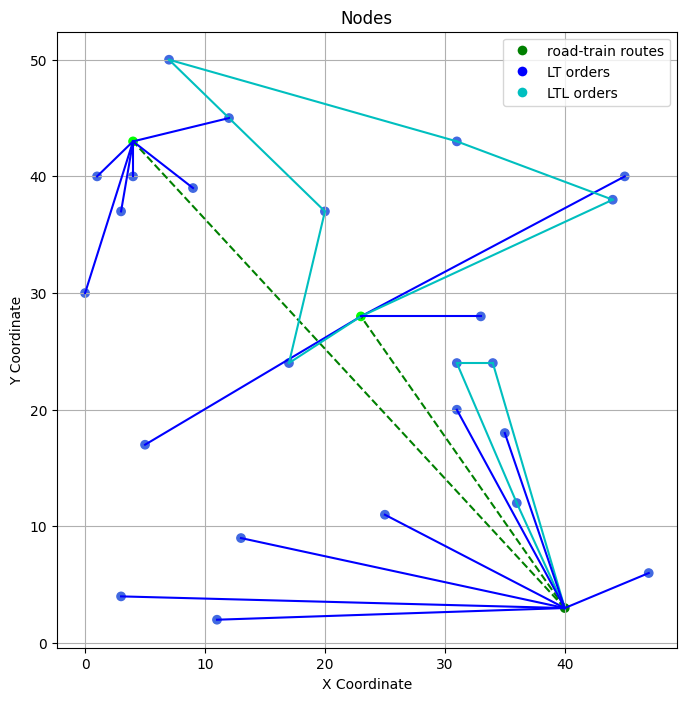

In [ ]:
model = RTOP_LA(nodes, num_costumers, num_terminals, LTL_orders, LTL_pattern, costumer_demands, number_of_trailers, trailer_capacity, number_experienced_drivers, c1, c2)

model.setup()
model.optimize()
model.plot_solution()
model.model_reset()